In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip install pygame

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
# from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/botocore/httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


In [4]:
env = gym.make('MountainCar-v0')
# env._max_episode_steps = 1000
env.seed(42)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

2
3
0
----


/opt/conda/lib/python3.7/site-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


In [5]:
'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()   
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()  
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action) 
''' env.step is used to calculate new state and obtain reward based on old state and action taken  ''' 

print(next_state)
print(reward)
print(done)
print(info)
print("----")

[-0.4452088  0.       ]
----
2
----
[-4.4479132e-01  4.1747934e-04]
-1.0
False
{}
----


In [6]:
# Iteration 1

In [7]:
BUFFER_SIZE = int(5e6)  # replay buffer size 
BATCH_SIZE = 128         # minibatch size 
GAMMA = 0.99            # discount factor
LR = 1e-4               # learning rate 
UPDATE_EVERY = 50      # how often to update the network (When Q target is present) 

In [8]:
# DQN

'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 64 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()

QNetwork2: Feel free to experiment more
'''

import torch
import torch.nn as nn  
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''

class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
#         self.fc4 = nn.Linear(fc1_units, fc2_units)
#         self.fc5 = nn.Linear(fc1_units, fc2_units)
#         self.fc6 = nn.Linear(fc1_units, fc2_units)
#         self.fc7 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))
#         x = F.relu(self.fc6(x))
#         x = F.relu(self.fc7(x))
        return self.fc3(x)

In [9]:
# Replay Buffer

import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''      
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
    

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()

In [11]:
def reward_function(position, velocity):
    # Calculate the distance to the goal position
    goal_position = 0.5
    distance = abs(position - goal_position)

    
    # Calculate the reward
    if distance < 0.1:
        reward = 0.0
    else:
        reward = -0.1 * distance + 0.01 * abs(velocity)
    
    return reward


In [12]:
''' Defining DQN Algorithm '''

import math

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    score_per_episode = []
    scores = []         
    steps_per_ep = []
    ''' list containing scores from each episode '''

    scores_window_printing = deque(maxlen=10) 
    ''' For printing in the graph '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start                    
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        num_steps = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            state_r = np.reshape(state, (1, 2))
            next_state_r = np.reshape(next_state, (1, 2))
            #Customised reward function
#             reward_new = reward + 100*((math.sin(3*next_state_r[0,0]) * 0.0025 + next_state_r[0,1]\
#                            * next_state_r[0,1]) - (math.sin(3*state_r[0,0]) * 0.0025 + state_r[0,1] * state_r[0,1]))
            reward_new = reward_function(next_state_r[0,0], next_state_r[0,1])
            agent.step(state, action, reward_new, next_state, done)
            state = next_state
            score += reward
            if done:
                num_steps = t
                break 

        scores_window.append(score)       
        scores_window_printing.append(score)   
        score_per_episode.append(score)
        steps_per_ep.append(num_steps)
        ''' save most recent score '''           

        eps = max(eps_end, eps_decay*eps) 
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}\tNumber of Steps: {}'.format(i_episode, np.mean(scores_window), num_steps))  
        if i_episode % 10 == 0: 
            scores.append(np.mean(scores_window_printing))        
        if np.mean(scores_window)>=-110.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
        if i_episode==1200:
            break
    return [np.array(scores),i_episode, np.array(score_per_episode), steps_per_ep]

In [13]:
num_runs = 10
scores_per_run = []
scores_10_run = []
episodes_per_run = []
steps_per_ep_run = []
for run in range(num_runs):
    print(f'------------------------------------------------------------------------------------------------------------------------------')
    print(f'Run {run+1}')
    print(f'------------------------------------------------------------------------------------------------------------------------------')
    print('\n')
    agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
    scores_10, episodes, score_per_episode, steps_per_ep = dqn()
    scores_per_run.append(score_per_episode)
    steps_per_ep_run.append(steps_per_ep)
    scores_10_run.append(scores_10)
    episodes_per_run.append(episodes)

------------------------------------------------------------------------------------------------------------------------------
Run 1
------------------------------------------------------------------------------------------------------------------------------


Episode 1	Average Score: -200.00	Number of Steps: 199
Episode 2	Average Score: -200.00	Number of Steps: 199
Episode 3	Average Score: -200.00	Number of Steps: 199
Episode 4	Average Score: -200.00	Number of Steps: 199
Episode 5	Average Score: -200.00	Number of Steps: 199
Episode 6	Average Score: -200.00	Number of Steps: 199
Episode 7	Average Score: -200.00	Number of Steps: 199
Episode 8	Average Score: -200.00	Number of Steps: 199
Episode 9	Average Score: -200.00	Number of Steps: 199
Episode 10	Average Score: -200.00	Number of Steps: 199
Episode 11	Average Score: -200.00	Number of Steps: 199
Episode 12	Average Score: -200.00	Number of Steps: 199
Episode 13	Average Score: -200.00	Number of Steps: 199
Episode 14	Average Score: -200.0

In [14]:
np.save('scores_per_run', scores_per_run)
np.save('scores_10_run', scores_10_run)
np.save('episodes_per_run', episodes_per_run)
np.save('steps_per_ep_run', steps_per_ep_run)

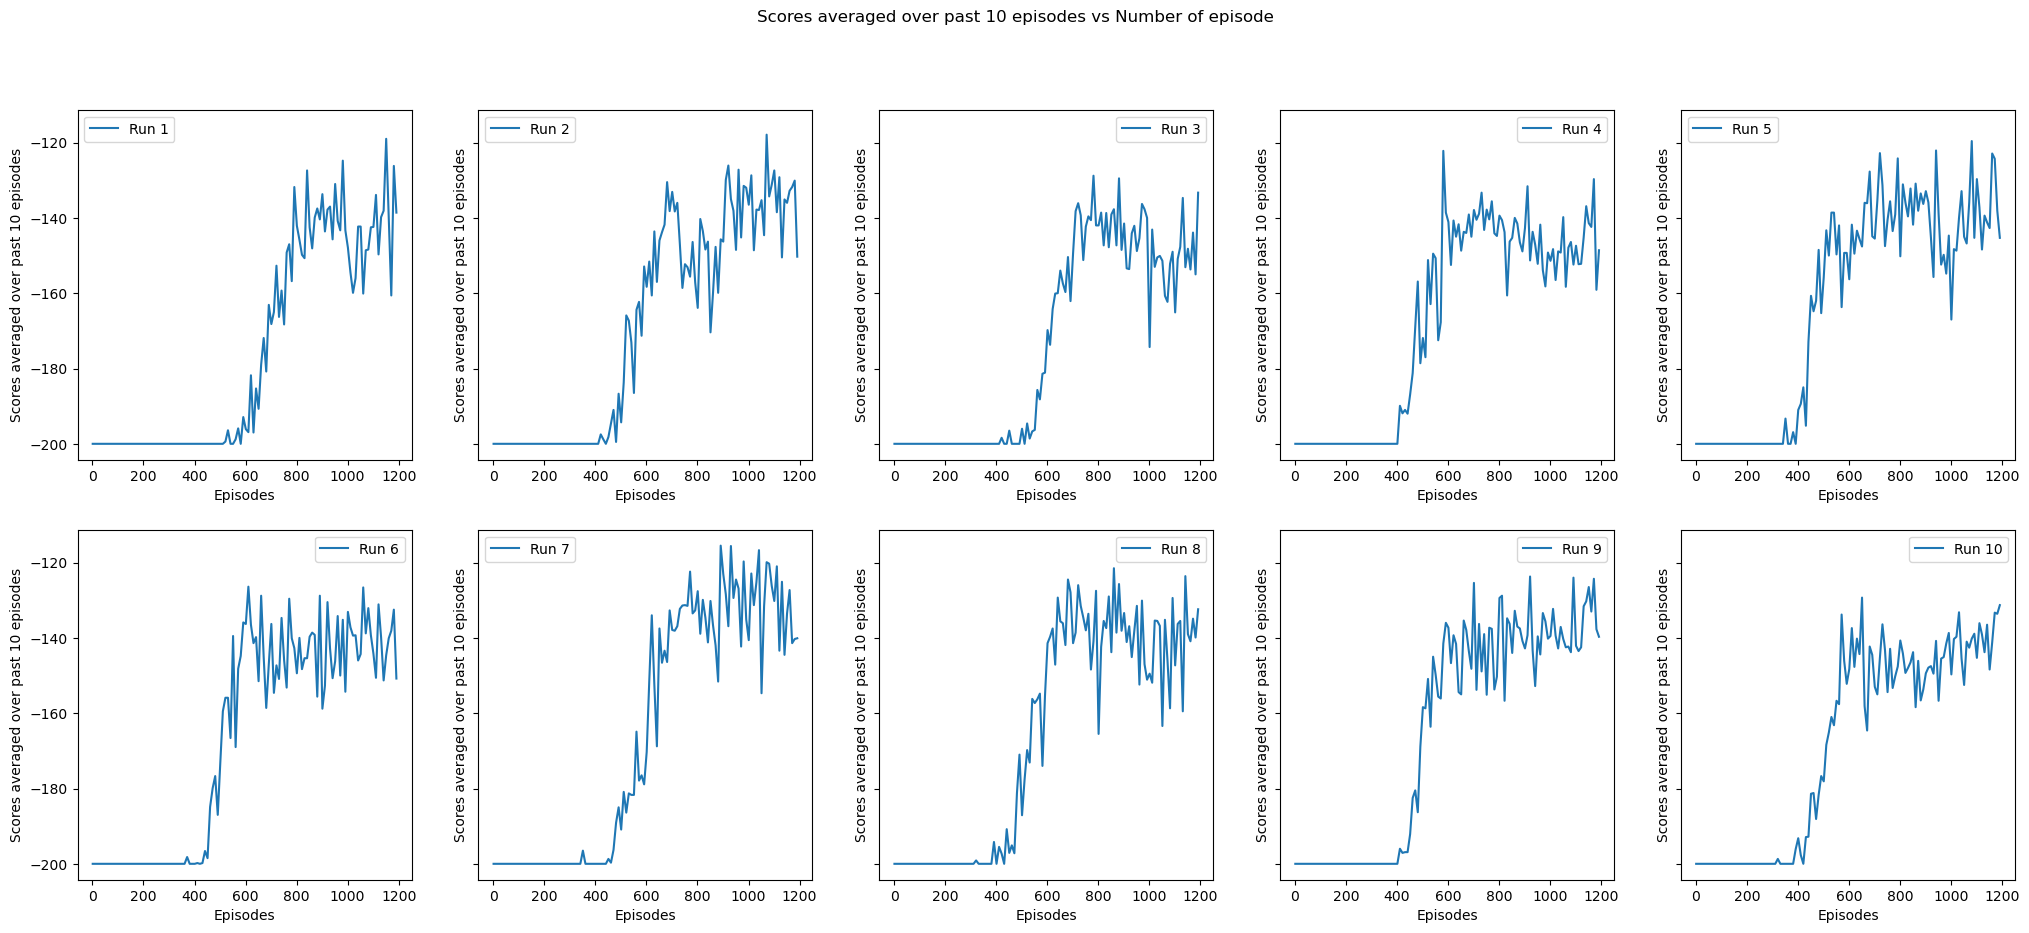

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=5, sharey=True, figsize=(25,10))
axs = axs.flatten()
for i, (s, e) in enumerate(zip(scores_10_run, episodes_per_run)):
    axs[i].plot(np.arange(1, (e//10)*10, 10), s, label=f'Run {i+1}')
    axs[i].legend()
    axs[i].set_xlabel(f'Episodes')
    axs[i].set_ylabel(f'Scores averaged over past 10 episodes')
plt.suptitle(f'Scores averaged over past 10 episodes vs Number of episode')
# plt.ylabel(f'Scores averaged over past 10 episodes')
plt.legend()
plt.savefig(f'avg_scores.png')

In [16]:
print(f'average number of episodes taken to solve the environment = {np.average(episodes_per_run)}')

average number of episodes taken to solve the environment = 1200.0
